## **Lab 4 - Linear models**

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import std

**Excercise 1 - modelling the height of people**

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header = 0)
d=d[d.age>=18] #just adults
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_ppc.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_ppc.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### **Task 1. Prior predictive checks**
- Plot histograms of mu, sigma and simulated height.
- Plot a joint distribution of mu and sigma.
- Check if samples are consistent with priors
- Check if observed data is possible to obtain using priors.

In [5]:
# Plot histograms of mu, sigma and simulated height.
sigma = sim.stan_variable('sigma')
mu = sim.stan_variable('mu')
height = sim.stan_variable('height')

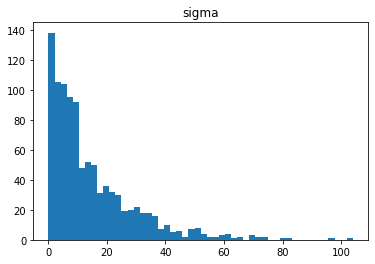

In [6]:
plt.hist(sigma, bins = 50)
plt.title('sigma')
plt.show()

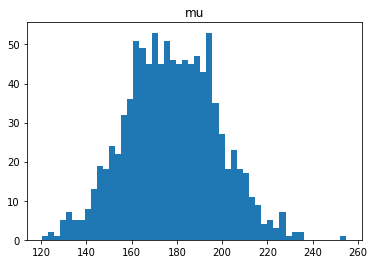

In [7]:
plt.hist(mu, bins = 50)
plt.title('mu')
plt.show()

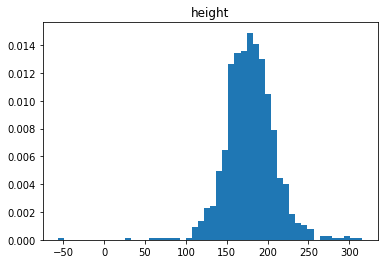

In [8]:
plt.hist(height, bins = 50, density = True)
plt.title('height')
plt.show()

array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

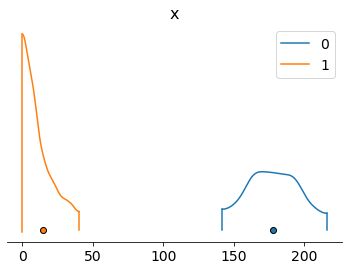

In [9]:
# Plot a joint distribution of mu and sigma.

az.plot_density([mu, sigma])

#### **Task 2. Model fit and evaluation**
- Plot a joint distribution of fitted mu and sigma.
- Plot histograms of data and simulated heights and evaluate the quality of model.

In [10]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_fit.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_fit.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\height_1_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/igach/Desktop/Python_folder/Topic_4/height_1_fit.hpp C:/Users/igach/Desktop/Python_folder/Topic_4/height_1_fit.stan
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_1_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused

In [11]:
fit=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [12]:
df = fit.summary()
print(df)

         Mean    MCSE  StdDev     5%    50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                      
lp__   -900.0  0.0250    0.98 -900.0 -900.0 -900.0  1600.0   4900.0    1.0
mu      150.0  0.0074    0.41  150.0  150.0  160.0  3100.0   9600.0    1.0
sigma     7.8  0.0050    0.29    7.3    7.8    8.3  3400.0  11000.0    1.0
height  150.0  0.1200    7.60  140.0  150.0  170.0  4200.0  13000.0    1.0


array([[<AxesSubplot:title={'center':'x'}>]], dtype=object)

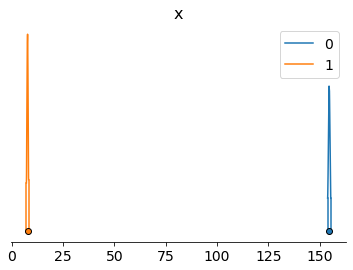

In [13]:
# Plot a joint distribution of fitted mu and sigma.

sigma_fit = fit.stan_variable('sigma')
mu_fit = fit.stan_variable('mu')
height_fit = fit.stan_variable('height')

az.plot_density([mu_fit, sigma_fit])

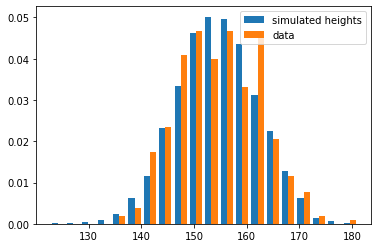

In [14]:
# Plot histograms of data and simulated heights and evaluate the quality of model.

data_height = d.height
sim_height = fit.stan_variable('height')

plt.hist([sim_height,data_height], bins = 20, density = True)
plt.legend(['simulated heights','data'],loc='upper right')
plt.show()

### **Adding predictor to the model - weight**

Create column c_weight in the dataframe containing weights substrated by their mean.

In [15]:
d['c_weight'] = d.weight - np.mean(d.weight)

In [16]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
print(data_sim)
sim=model_ppc.sample(data=data_sim,
                     iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2a_ppc.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2a_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\height_2a_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/igach/Desktop/Python_folder/Topic_4/height_2a_ppc.hpp C:/Users/igach/Desktop/Python_folder/Topic_4/height_2a_ppc.stan
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2a_ppc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2a_ppc.stan', line 10, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wi

{'N': 50, 'weight': array([-13.91943352, -13.26797358, -12.61651364, -11.9650537 ,
       -11.31359376, -10.66213383, -10.01067389,  -9.35921395,
        -8.70775401,  -8.05629407,  -7.40483413,  -6.75337419,
        -6.10191425,  -5.45045432,  -4.79899438,  -4.14753444,
        -3.4960745 ,  -2.84461456,  -2.19315462,  -1.54169468,
        -0.89023474,  -0.23877481,   0.41268513,   1.06414507,
         1.71560501,   2.36706495,   3.01852489,   3.66998483,
         4.32144477,   4.9729047 ,   5.62436464,   6.27582458,
         6.92728452,   7.57874446,   8.2302044 ,   8.88166434,
         9.53312428,  10.18458421,  10.83604415,  11.48750409,
        12.13896403,  12.79042397,  13.44188391,  14.09334385,
        14.74480379,  15.39626373,  16.04772366,  16.6991836 ,
        17.35064354,  18.00210348])}


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### **Task 4. Prior predictive checks**
Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [17]:
beta = sim.stan_variable('beta')
alpha = sim.stan_variable('alpha')

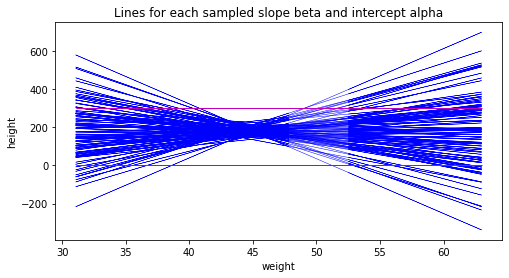

In [19]:
fig, axes = plt.subplots(1, 1, figsize = (8, 4))

for i in range(100):
    axes.plot(d.weight, alpha[i]+beta[i]*d.c_weight, linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('weight')
axes.set_ylabel('height')
axes.hlines([0, 300], xmin = d.weight.min(), xmax = d.weight.max(), linestyles = '-',linewidth = 1, color = 'm')

#### **Modifying prior**
If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.

In [20]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2b_ppc.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2b_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\height_2b_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/igach/Desktop/Python_folder/Topic_4/height_2b_ppc.hpp C:/Users/igach/Desktop/Python_folder/Topic_4/height_2b_ppc.stan
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2b_ppc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2b_ppc.stan', line 10, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wi

In [21]:
sim_2b_ppc = model_ppc.sample(data = data_sim,
                     iter_sampling = R,
                     iter_warmup = 0,
                     chains = 1,
                     refresh = R,
                     fixed_param = True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### **Task 5. Prior predictive checks**
- Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
- For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

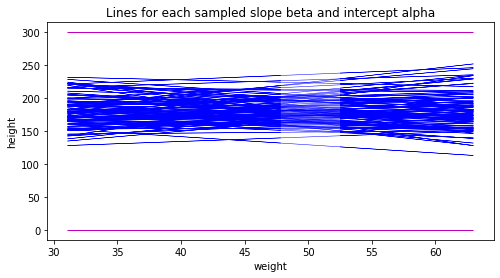

In [22]:
beta = sim_2b_ppc.stan_variable('beta')
alpha = sim_2b_ppc.stan_variable('alpha')
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

for i in range(100):
    axes.plot(d.weight, alpha[i]+beta[i]*d.c_weight, linewidth = 0.5, color = 'b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('weight')
axes.set_ylabel('height')
axes.hlines([0, 300], xmin = d.weight.min(), xmax = d.weight.max(), linestyles = '-',linewidth = 1, color = 'm')

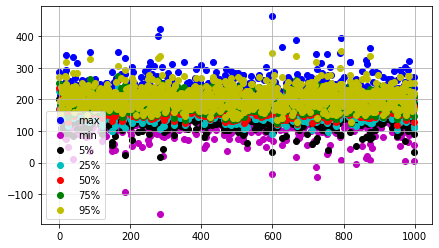

In [26]:
# For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot)

sim_height = sim_2b_ppc.stan_variable('height')
x_list = [i for i in range (len(sim_height))]
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []
for vector in sim_height:
    five_quantile.append(np.percentile(vector,5))
    twofive_quantile.append(np.percentile(vector,25))
    fifty_quantile.append(np.percentile(vector,50))
    sevenFive_quantile.append(np.percentile(vector,75))
    nineFive_qantile.append(np.percentile(vector,95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1,1,figsize=(7,4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

### **Fitting data**

In [27]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2_fit.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\height_2_fit.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\height_2_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/igach/Desktop/Python_folder/Topic_4/height_2_fit.hpp C:/Users/igach/Desktop/Python_folder/Topic_4/height_2_fit.stan
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2_fit.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/igach/Desktop/Python_folder/Topic_4/height_2_fit.stan', line 25, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be r

#### **Task 6. Preparing data for fit**
Create data_fit dictionary containing data from N first rows of dataframe

In [28]:
N = 150

d['s_weight'] = d['c_weight']/d['weight'].std()
d_short = d.head(N)
data_fit = dict(N= len(d_short),
                weight = d_short.s_weight.values,
                heights = d_short.height.values)

In [29]:
fit=model_2_fit.sample(data=data_fit, seed = 28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### **Task 7. Evaluating model**
- Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
- For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.

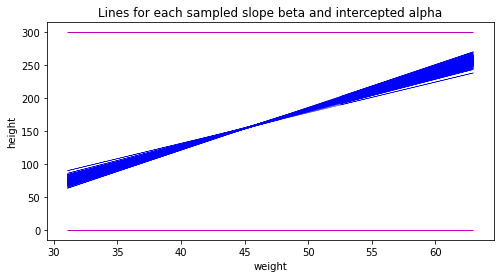

In [30]:
beta = fit.stan_variable('beta')
alpha = fit.stan_variable('alpha')

fig, axes = plt.subplots(1,1,figsize=(8, 4))

for i in range(100):
    axes.plot(d.weight, alpha[i]+beta[i]*d.c_weight, linewidth = 0.5, color = 'b')
plt.title("Lines for each sampled slope beta and intercepted alpha")
axes.set_xlabel('weight')
axes.set_ylabel('height')
axes.hlines([0, 300], xmin = d.weight.min(), xmax = d.weight.max(), linestyles = '-',linewidth = 1, color = 'm')

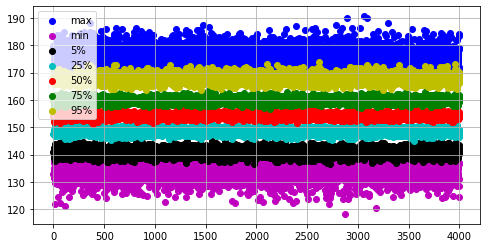

In [31]:
sim_height = fit.stan_variable('height')
x_list = [i for i in range (len(sim_height))]
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []
for vector in sim_height:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1,1,figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

## **Lab 4 - Linear models - part 2**

We will generate fake data, that will simulate dataset of 100 outputs from 200 dimensional linear model along with appropriate predictors. Our goal will be estimation of the parameters of the model.

In [33]:
data_genetator = CmdStanModel(stan_file = 'generate_data.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\generate_data.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\generate_data.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\generate_data.exe


In [34]:
I = 3          #number of letters in name
N = 13         #number of letters in surname
DoB= 180899    #date of birth
seed=int(DoB*1e4+100*I+N)
print(seed)
generated_data = data_genetator.sample(chains=1, iter_sampling=1, iter_warmup=0, fixed_param=True,seed=seed)

INFO:cmdstanpy:CmdStan start processing


1808990313


chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


### **Coefficients of linear model**
Only few of beta coefficients are significantly greater than 0.

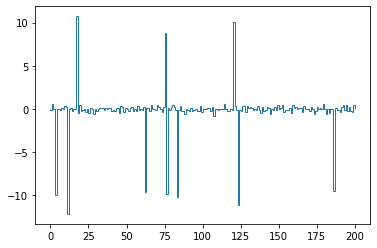

In [35]:
beta_s = generated_data.stan_variable('beta')
plt.stairs(generated_data.stan_variable('beta')[0])

This is an issue called sparsity. We will try to exploit that when infering the results via changing the prior structure.

### **Model 1 - uniform prior for beta**

In [36]:
model_uniform = CmdStanModel(stan_file = 'model1.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\model1.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\model1.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\model1.exe


In [37]:
data_for_inference = {'N':100,
                      'M':200,
                      'X':generated_data.stan_variable('X')[0],
                      'y':generated_data.stan_variable('y')[0]
                      }

In [38]:
fit_unf = model_uniform.sample(data=data_for_inference,seed=seed)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:13 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:21 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:30 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:37 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:43 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:50 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:57 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 01:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 01:10 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 01:17 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 01:24 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 01:31 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎ 


INFO:cmdstanpy:CmdStan done processing.


In [39]:
print(fit_unf.diagnose())

Processing csv files: C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model1-20220404235517_1.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model1-20220404235517_2.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model1-20220404235517_3.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model1-20220404235517_4.csv

Checking sampler transitions treedepth.
3997 of 4000 (99.92%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3 of 4000 (0.07%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.10, is

#### **Task 1. Evaluating the model**
- Analyse the diagnosis of model. What sampling issues occured?
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

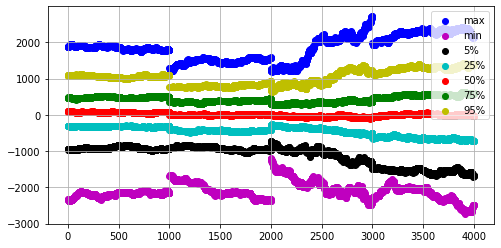

In [40]:
fit_beta = fit_unf.stan_variable('beta')
x_list = [i for i in range (len(fit_beta))]
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []

for vector in fit_beta:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

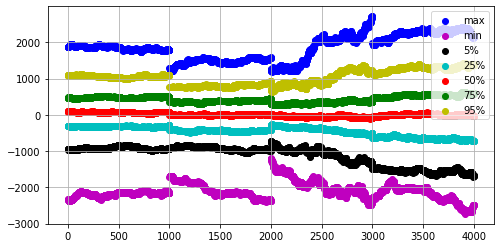

In [41]:
# Substract true values from fitted betas and make the same plot (residues).

result = fit_beta - beta_s
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []
for vector in result:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

### **Model 2 - Narrow weakly informative prior**
We try to improve sampling by regularizing the search space with normal priors. This is prior used in ridge regression (but here is the bayesian context).

In [42]:
model_reg = CmdStanModel(stan_file = 'model2.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\model2.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\model2.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\model2.exe


In [43]:
fit_reg = model_reg.sample(data = data_for_inference, seed = seed)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60


INFO:cmdstanpy:CmdStan done processing.


In [44]:
print(fit_reg.diagnose())

Processing csv files: C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model2-20220404235927_1.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model2-20220404235927_2.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model2-20220404235927_3.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model2-20220404235927_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



### **Task 2. Evaluating the model**
- Analyse the diagnosis of model. Are the sampling problems solved
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

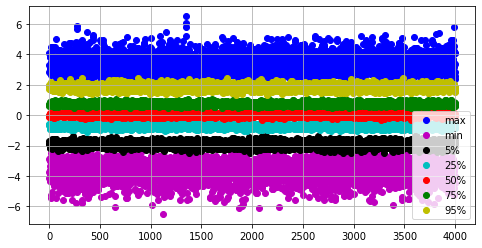

In [45]:
fit_beta = fit_reg.stan_variable('beta')
x_list = [i for i in range (len(fit_beta))]
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []

for vector in fit_beta:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

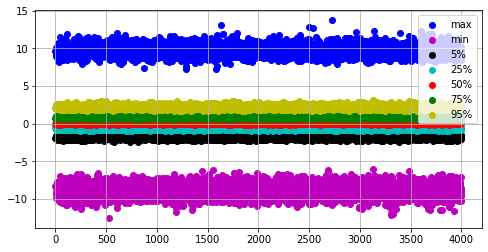

In [46]:
result = fit_beta - beta_s
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []

for vector in result:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

### **Model 3 - Sparsity enforcing prior**
We will now try to enforce shrinking of small parameters using a Laplace prior. This is a prior that is used in Lasso regression. (but here is the bayesian context)

In [48]:
model_lap = CmdStanModel(stan_file = 'model3.stan')

INFO:cmdstanpy:compiling stan file C:\Users\igach\Desktop\Python_folder\Topic_4\model3.stan to exe file C:\Users\igach\Desktop\Python_folder\Topic_4\model3.exe
INFO:cmdstanpy:compiled model executable: C:\Users\igach\Desktop\Python_folder\Topic_4\model3.exe


In [49]:
fit_lap = model_lap.sample(data=data_for_inference,seed=seed,adapt_delta=0.99,max_treedepth=12)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:22 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:31 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:39 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:47 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:54 Iteration:  500 / 2000 [ 25%]  (Warmup)







chain 1 |███▋      | 01:16 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 01:29 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |████▌     | 01:46 Iteration:  800 / 2000 [ 40%]  (Warmup)








chain 1 |█████▍    | 02:08 Iteration: 1000 / 2000 [ 50%]  (Warmup)




chain 1 |█████▉    | 02:32 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 02:54 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 03:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chai


INFO:cmdstanpy:CmdStan done processing.


In [50]:
print(fit_lap.diagnose())

Processing csv files: C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model3-20220405000225_1.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model3-20220405000225_2.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model3-20220405000225_3.csv, C:\Users\igach\AppData\Local\Temp\tmprnxzvnj6\model3-20220405000225_4.csv

Checking sampler transitions treedepth.
1998 of 4000 (49.95%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.02, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following parameters had split R-hat g

#### **Task 3. Evaluating model**
- Analyse the diagnosis of model. Are the sampling problems solved. Are there any new sampling issues?
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

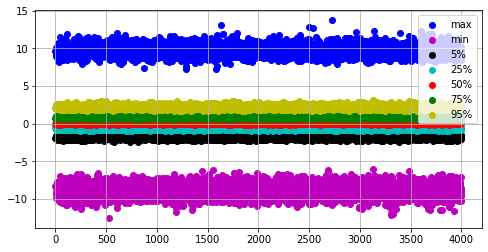

In [51]:
fit_beta = fit_lap.stan_variable('beta')
x_list = [i for i in range (len(fit_beta))]
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []

for vector in result:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()

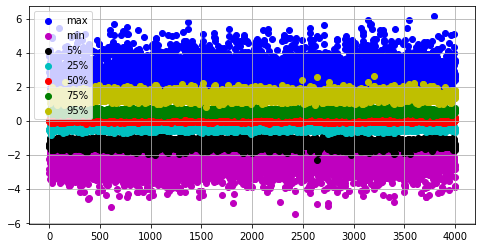

In [52]:
result = fit_beta - beta_s
max_height = []
min_height = []

five_quantile = []
twofive_quantile = []
fifty_quantile = []
sevenFive_quantile = []
nineFive_qantile = []

for vector in result:
    five_quantile.append(np.percentile(vector, 5))
    twofive_quantile.append(np.percentile(vector, 25))
    fifty_quantile.append(np.percentile(vector, 50))
    sevenFive_quantile.append(np.percentile(vector, 75))
    nineFive_qantile.append(np.percentile(vector, 95))
    max_height.append(np.max(vector))
    min_height.append(np.min(vector))

fig, axes = plt.subplots(1, 1, figsize = (8, 4))
plt.scatter(x_list, max_height, color = 'b')
plt.scatter(x_list, min_height, color = 'm')
plt.scatter(x_list, five_quantile, color = 'k')
plt.scatter(x_list, twofive_quantile, color = 'c')
plt.scatter(x_list, fifty_quantile,  color = 'r')
plt.scatter(x_list, sevenFive_quantile, color = 'g')
plt.scatter(x_list, nineFive_qantile,  color = 'y') 
plt.legend(['max','min','5%','25%','50%','75%','95%'])
plt.grid()